# Noisy vs noiseless NN, linear regression, and logistic regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPORT_DIR_NAME = 'teaser_plot'
NN_EXPERIMENT_NAME = 'teaser_plot_nn'
NN_NOISELESS_EXPERIMENT_NAME = 'neural_networks_teaser_plot_noiseless'
LINREG_EXPERIMENT_NAME = 'teaser_plot_linreg'
LOGREG_EXPERIMENT_NAME = 'teaser_plot_logreg'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPORT_DIR_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


In [6]:
FIGURE_SIZE = (1.8, 1.7)
LEGEND_FIGURE_SIZE_NN = (1.8, 0.5)
LEGEND_FIGURE_SIZE_OTHERS = (2.4, 0.5)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT
AXIS_LABEL_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [7]:
y_axis_label = r'Risk($\lambda \to 0$) - Risk($\lambda_{\textnormal{opt}}$)'

## Neural networks on noiseless MNIST

In [8]:
client = mlflow.tracking.MlflowClient()
nn_experiment = client.get_experiment_by_name(NN_EXPERIMENT_NAME)
nn_runs = mlflow.search_runs(
    nn_experiment.experiment_id
)
nn_runs = nn_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert number of MLP units to integer since they are stored as "[NUM_UNITS]" and soprt by them
nn_runs['params.mlp_units'] = nn_runs['params.mlp_units'].str.strip('[] \t').astype(int)
nn_runs = nn_runs.sort_values(['params.mlp_units'])
print('Loaded', len(nn_runs), 'runs of experiment', NN_EXPERIMENT_NAME)
assert nn_runs['status'].eq('FINISHED').all()

target_metrics = ('test_std_accuracy', 'test_robust_accuracy')
metrics = ir.mlflow.load_metrics(nn_runs, target_metrics, client)
print('Loaded', len(target_metrics), 'metrics of', len(metrics.keys()), 'runs of experiment', NN_EXPERIMENT_NAME)

AVERAGE_OVER_LAST_K = 10

best_std_accuracies = ir.plots.find_best_metrics(metrics, 'test_std_accuracy', maximize=True)
best_robust_accuracies = ir.plots.find_best_metrics(metrics, 'test_robust_accuracy', maximize=True)
last_std_accuracies = ir.plots.find_last_metrics(metrics, 'test_std_accuracy', average_over=AVERAGE_OVER_LAST_K)
last_robust_accuracies = ir.plots.find_last_metrics(metrics, 'test_robust_accuracy', average_over=AVERAGE_OVER_LAST_K)

current_std_metrics = np.zeros((len(nn_runs), AVERAGE_OVER_LAST_K))
current_adv_metrics = np.zeros((len(nn_runs), AVERAGE_OVER_LAST_K))
current_std_best = np.zeros((len(nn_runs),))
current_adv_best = np.zeros((len(nn_runs),))
for idx, run_id in enumerate(nn_runs['run_id']):
    current_std_metrics[idx, :] = 1.0 - last_std_accuracies[run_id]
    current_adv_metrics[idx, :] = 1.0 - last_robust_accuracies[run_id]
    current_std_best[idx] = 1.0 - best_std_accuracies[run_id]
    current_adv_best[idx] = 1.0 - best_robust_accuracies[run_id]

nn_std_gaps = np.mean(current_std_metrics, axis=-1) - current_std_best 
nn_adv_gaps = np.mean(current_adv_metrics, axis=-1) - current_adv_best


Loaded 17 runs of experiment teaser_plot_nn
Loaded 2 metrics of 17 runs of experiment teaser_plot_nn


In [9]:
client = mlflow.tracking.MlflowClient()
nn_noiseless_experiment = client.get_experiment_by_name(NN_NOISELESS_EXPERIMENT_NAME)
nn_noiseless_runs = mlflow.search_runs(
    nn_noiseless_experiment.experiment_id
)
nn_noiseless_runs = nn_noiseless_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert number of MLP units to integer since they are stored as "[NUM_UNITS]" and soprt by them
nn_noiseless_runs['params.mlp_units'] = nn_noiseless_runs['params.mlp_units'].str.strip('[] \t').astype(int)
nn_noiseless_runs = nn_noiseless_runs.sort_values(['params.mlp_units'])
print('Loaded', len(nn_noiseless_runs), 'runs of experiment', NN_NOISELESS_EXPERIMENT_NAME)
assert nn_noiseless_runs['status'].eq('FINISHED').all()

metrics = ir.mlflow.load_metrics(nn_noiseless_runs, target_metrics, client)
print('Loaded', len(target_metrics), 'metrics of', len(metrics.keys()), 'runs of experiment', NN_NOISELESS_EXPERIMENT_NAME)

AVERAGE_OVER_LAST_K = 10

best_std_accuracies = ir.plots.find_best_metrics(metrics, 'test_std_accuracy', maximize=True)
best_robust_accuracies = ir.plots.find_best_metrics(metrics, 'test_robust_accuracy', maximize=True)
last_std_accuracies = ir.plots.find_last_metrics(metrics, 'test_std_accuracy', average_over=AVERAGE_OVER_LAST_K)
last_robust_accuracies = ir.plots.find_last_metrics(metrics, 'test_robust_accuracy', average_over=AVERAGE_OVER_LAST_K)

current_std_metrics = np.zeros((len(nn_noiseless_runs), AVERAGE_OVER_LAST_K))
current_adv_metrics = np.zeros((len(nn_noiseless_runs), AVERAGE_OVER_LAST_K))
current_std_best = np.zeros((len(nn_noiseless_runs),))
current_adv_best = np.zeros((len(nn_noiseless_runs),))
for idx, run_id in enumerate(nn_noiseless_runs['run_id']):
    current_std_metrics[idx, :] = 1.0 - last_std_accuracies[run_id]
    current_adv_metrics[idx, :] = 1.0 - last_robust_accuracies[run_id]
    current_std_best[idx] = 1.0 - best_std_accuracies[run_id]
    current_adv_best[idx] = 1.0 - best_robust_accuracies[run_id]

nn_noiseless_std_gaps = np.mean(current_std_metrics, axis=-1) - current_std_best 
nn_noiseless_adv_gaps = np.mean(current_adv_metrics, axis=-1) - current_adv_best

Loaded 17 runs of experiment neural_networks_teaser_plot_noiseless
Loaded 2 metrics of 17 runs of experiment neural_networks_teaser_plot_noiseless


In [10]:
noiseless_cycle_idx = 0
noisy_cycle_idx = 1

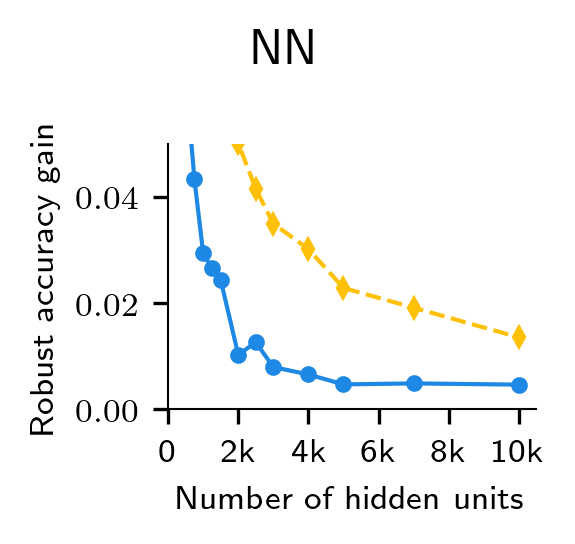

In [11]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.plot(
    nn_noiseless_runs[f'params.mlp_units'],
    nn_noiseless_adv_gaps,
    label=r'Pruned data',
    ls=ir.plots.LINESTYLE_MAP[noiseless_cycle_idx],
    c=f'C{noiseless_cycle_idx}',
    marker=ir.plots.MARKER_MAP[noiseless_cycle_idx]
)

ax.plot(
    nn_runs[f'params.mlp_units'],
    nn_adv_gaps,
    label=r'Original data',
    ls=ir.plots.LINESTYLE_MAP[noisy_cycle_idx],
    c=f'C{noisy_cycle_idx}',
    marker=ir.plots.MARKER_MAP[noisy_cycle_idx]
)

ax.set_xlabel('Number of hidden units', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel('Robust accuracy gain', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylim(bottom=0, top=0.05)
ax.set_xlim(left=0)
xticks = (0, 2000, 4000, 6000, 8000, 10000)
ax.set_xticks(xticks)
ax.set_xticklabels(
    f'{val // 1000}k' if val > 0 else '0'
    for val in xticks
)

if SHOW_TITLES:
    fig.suptitle('NN')

export_fig(fig, f'teaser_plot_nn.pdf')
plt.show()

In [12]:
# Legend
legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE_NN)

handles, labels = ax.get_legend_handles_labels()
legend_fig.legend(
    handles,
    labels,
    loc='center',
    ncol=2,
    mode='expand',
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(legend_fig, f'teaser_plot_nn_legend.pdf')

<Figure size 540x150 with 0 Axes>

## Linear regression ST

In [13]:
client = mlflow.tracking.MlflowClient()
linreg_experiment = client.get_experiment_by_name(LINREG_EXPERIMENT_NAME)
linreg_runs = mlflow.search_runs(
    linreg_experiment.experiment_id
)
linreg_runs = linreg_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
linreg_runs['params.data_dim'] = linreg_runs['params.data_dim'].astype(int)
linreg_runs['params.test_attack_epsilon'] = linreg_runs['params.test_attack_epsilon'].astype(np.float)
linreg_runs['params.l2_lambda'] = linreg_runs['params.l2_lambda'].astype(np.float)
linreg_runs['params.data_gaussian_noise_variance'] = linreg_runs['params.data_gaussian_noise_variance'].astype(np.float)
linreg_runs = linreg_runs.sort_values(['params.data_dim', 'params.l2_lambda', 'params.data_gaussian_noise_variance'], ascending=True)
print('Loaded', len(linreg_runs), 'runs of experiment', LINREG_EXPERIMENT_NAME)
assert linreg_runs['status'].eq('FINISHED').all()

Loaded 506 runs of experiment teaser_plot_linreg


In [14]:
num_samples, = linreg_runs['params.num_train_samples'].astype(int).unique()

nonoise, covariate_noise = np.sort(linreg_runs['params.data_gaussian_noise_variance'].unique())
assert nonoise == 0 and covariate_noise > 0

linreg_noiseless_runs = linreg_runs[linreg_runs['params.data_gaussian_noise_variance'] == 0]
linreg_noise_runs = linreg_runs[linreg_runs['params.data_gaussian_noise_variance'] > 0]

linreg_noreg_noiseless_runs = linreg_noiseless_runs[linreg_noiseless_runs['params.l2_lambda'] == 0]
linreg_bestreg_noiseless_runs = linreg_noiseless_runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

linreg_noreg_noise_runs = linreg_noise_runs[linreg_noise_runs['params.l2_lambda'] == 0]
linreg_bestreg_noise_runs = linreg_noise_runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

linreg_noiseless_std_gaps = linreg_noreg_noiseless_runs['metrics.true_std_risk'].values - linreg_bestreg_noiseless_runs['metrics.true_std_risk'].values
linreg_noiseless_robust_gaps = linreg_noreg_noiseless_runs['metrics.true_robust_risk'].values - linreg_bestreg_noiseless_runs['metrics.true_robust_risk'].values
linreg_noise_std_gaps = linreg_noreg_noise_runs['metrics.true_std_risk'].values - linreg_bestreg_noise_runs['metrics.true_std_risk'].values
linreg_noise_robust_gaps = linreg_noreg_noise_runs['metrics.true_robust_risk'].values - linreg_bestreg_noise_runs['metrics.true_robust_risk'].values

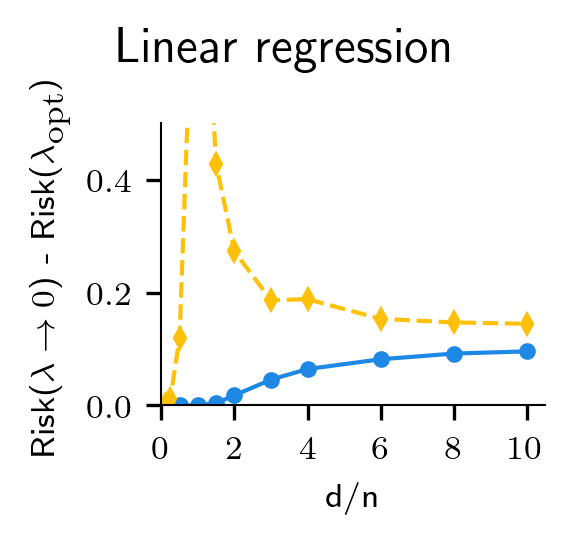

In [15]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.plot(
    linreg_noreg_noiseless_runs[f'params.data_dim'].unique() / float(num_samples),
    linreg_noiseless_robust_gaps,
    label=r'Without noise',
    ls=ir.plots.LINESTYLE_MAP[noiseless_cycle_idx],
    marker=ir.plots.MARKER_MAP[noiseless_cycle_idx],
    c=f'C{noiseless_cycle_idx}'
)

ax.plot(
    linreg_noreg_noise_runs[f'params.data_dim'].unique() / float(num_samples),
    linreg_noise_robust_gaps,
    label=r'With noise',
    ls=ir.plots.LINESTYLE_MAP[noisy_cycle_idx],
    marker=ir.plots.MARKER_MAP[noisy_cycle_idx],
    c=f'C{noisy_cycle_idx}'
)

ax.set_xlabel('d/n', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel(y_axis_label, fontsize=AXIS_LABEL_FONT_SIZE)
xticks = (0, 2, 4, 6, 8, 10)
ax.set_xticks(xticks)
ax.set_ylim(bottom=0.0, top=0.5)
ax.set_xlim(left=0)

if SHOW_TITLES:
    fig.suptitle('Linear regression')

export_fig(fig, f'teaser_plot_linreg.pdf')
plt.show()


## Logistic regression with consistent attacks

In [16]:
client = mlflow.tracking.MlflowClient()
logreg_experiment = client.get_experiment_by_name(LOGREG_EXPERIMENT_NAME)
logreg_runs = mlflow.search_runs(
    logreg_experiment.experiment_id
)
logreg_runs = logreg_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
logreg_runs['params.data_dim'] = logreg_runs['params.data_dim'].astype(int)
logreg_runs['params.train_attack_epsilon'] = logreg_runs['params.train_attack_epsilon'].astype(np.float)
logreg_runs['params.test_attack_epsilon'] = logreg_runs['params.test_attack_epsilon'].astype(np.float)
logreg_runs['params.l2_lambda'] = logreg_runs['params.l2_lambda'].astype(np.float)
logreg_runs['params.label_noise'] = logreg_runs['params.label_noise'].astype(np.float)
logreg_runs = logreg_runs.sort_values(['params.data_dim', 'params.l2_lambda'])
print('Loaded', len(logreg_runs), 'runs of experiment', LOGREG_EXPERIMENT_NAME)
assert logreg_runs['status'].eq('FINISHED').all()

Loaded 528 runs of experiment teaser_plot_logreg


In [17]:
num_samples, = logreg_runs['params.data_num_train_samples'].astype(int).unique()

nonoise, label_noise = np.sort(logreg_runs['params.label_noise'].unique())
assert nonoise == 0 and label_noise > 0

logreg_noiseless_runs = logreg_runs[logreg_runs['params.label_noise'] == 0]
logreg_noise_runs = logreg_runs[logreg_runs['params.label_noise'] > 0]

logreg_noreg_noiseless_runs = logreg_noiseless_runs[logreg_noiseless_runs['params.l2_lambda'] == 0]
logreg_bestreg_noiseless_runs = logreg_noiseless_runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

logreg_noreg_noise_runs = logreg_noise_runs[logreg_noise_runs['params.l2_lambda'] == 0]
logreg_bestreg_noise_runs = logreg_noise_runs.groupby('params.data_dim').aggregate({'metrics.true_std_risk': 'min', 'metrics.true_robust_risk': 'min'})

logreg_noiseless_std_gaps = logreg_noreg_noiseless_runs['metrics.true_std_risk'].values - logreg_bestreg_noiseless_runs['metrics.true_std_risk'].values
logreg_noiseless_robust_gaps = logreg_noreg_noiseless_runs['metrics.true_robust_risk'].values - logreg_bestreg_noiseless_runs['metrics.true_robust_risk'].values
logreg_noise_std_gaps = logreg_noreg_noise_runs['metrics.true_std_risk'].values - logreg_bestreg_noise_runs['metrics.true_std_risk'].values
logreg_noise_robust_gaps = logreg_noreg_noise_runs['metrics.true_robust_risk'].values - logreg_bestreg_noise_runs['metrics.true_robust_risk'].values

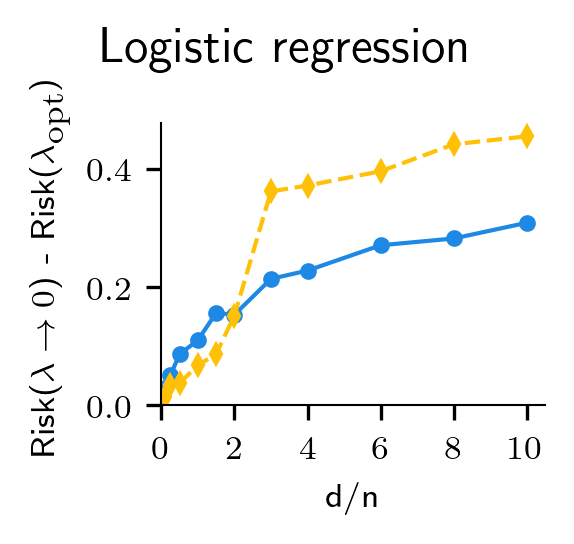

In [18]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.plot(
    logreg_noreg_noiseless_runs[f'params.data_dim'].unique() / float(num_samples),
    logreg_noiseless_robust_gaps,
    label=r'Without noise',
    ls=ir.plots.LINESTYLE_MAP[noiseless_cycle_idx],
    marker=ir.plots.MARKER_MAP[noiseless_cycle_idx],
    c=f'C{noiseless_cycle_idx}'
)

ax.plot(
    logreg_noreg_noise_runs[f'params.data_dim'].unique() / float(num_samples),
    logreg_noise_robust_gaps,
    label=r'With noise',
    ls=ir.plots.LINESTYLE_MAP[noisy_cycle_idx],
    marker=ir.plots.MARKER_MAP[noisy_cycle_idx],
    c=f'C{noisy_cycle_idx}'
)

ax.set_xlabel('d/n', fontsize=AXIS_LABEL_FONT_SIZE)
ax.set_ylabel(y_axis_label, fontsize=AXIS_LABEL_FONT_SIZE)
xticks = (0, 2, 4, 6, 8, 10)
ax.set_xticks(xticks)
ax.set_ylim(bottom=0.0)
ax.set_xlim(left=0)

if SHOW_TITLES:
    fig.suptitle('Logistic regression')

export_fig(fig, f'teaser_plot_logreg.pdf')
plt.show()

In [19]:
# Legend
legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE_OTHERS)

handles, labels = ax.get_legend_handles_labels()
legend_fig.legend(
    handles,
    labels,
    loc='center',
    ncol=2,
    mode='expand',
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(legend_fig, f'teaser_plot_other_legend.pdf')

<Figure size 720x150 with 0 Axes>